In [2]:
%load_ext autoreload
%autoreload 2
from collections import defaultdict
import pandas as pd
pd.set_option('display.max_colwidth', 255)
import numpy as np
import pickle
import sys
import analyze_utils
import seaborn as sns
sys.path.append('..')
from model_utils import prompt_classification
import data

In [97]:
class fake_args:
    template_num_task_phrasing = 0
    max_dset_size = 2000
    max_digit = 10
    seed = 1
    train_split_frac = 0.25 # we'll just test on 10% so this runs more efficiently
    task_name = 'sst2_train'

    # these will be varied
    n_shots = 1
    

args = fake_args()
np.random.seed(args.seed)
checkpoint = 'EleutherAI/gpt-j-6B'
task_name = 'sst2_train'

model = prompt_classification.create_model(checkpoint)

# Calculate accuracies of the found prompts

In [ ]:
prompts_df = pickle.load(open('../results/autoprompt_sentiment/prompts.pkl', 'rb'))
prompts_df = prompts_df.reset_index()
prompts_df['task_name'] = prompts_df['task_name'].map(lambda s: s.replace('train', 'test'))
prompts_df

In [ ]:
accs = []
losses = []

n_shots = 1
for i, row in prompts_df.iterrows(): 
    restrict_to_valid_answers = False
    args.task_name = row['task_name']
    args.n_shots = n_shots
    (dset, dset_test), check_answer_func, descr = data.get_data(
        args, args.task_name, n_shots=args.n_shots,
        train_split_frac=args.train_split_frac
    )
    prompt_actual = row['prefixes']
    batch_size = 32
    loss, acc = prompt_classification.test_model_on_task_with_prefix(
        dset=dset, model=model,
        prefix=prompt_actual,
        multi_token=False,
        verbose=False,
        restrict_to_valid_answers=restrict_to_valid_answers,
        batch_size=batch_size,
    )
    print(f'loss {loss:.2f} / acc ={acc:.2f}')
    losses.append(loss)
    accs.append(acc)

prompts_df['acc'] = accs
prompts_df['losses'] = losses

# Baseline accuracies

In [ ]:
# test
data.get_data(
    args, 'sst2_test', n_shots=args.n_shots,
    train_split_frac=args.train_split_frac
)

print('calculating accs...')
n_shots = 1
d = defaultdict(list)

for train_task_name in prompts_df['task_name'].unique(): 
    test_task_name = train_task_name.replace('train', 'test') # sst2_train -> sst2_test, etc...
    print(test_task_name)
    restrict_to_valid_answers = False
    args.task_name = test_task_name
    args.n_shots = n_shots
    (dset, dset_test), check_answer_func, descr = data.get_data(
        args, args.task_name, n_shots=args.n_shots,
        train_split_frac=args.train_split_frac
    )
    for prompt in ['', 'manual']:
        d['checkpoint'].append(checkpoint)
        d['prompt'].append(prompt)
        d['task_name'].append(test_task_name)
        d['n_shots'].append(n_shots)
        d['restrict_to_valid_answers'].append(restrict_to_valid_answers)
        if prompt == 'manual':
            prompt_actual = descr
        else:
            prompt_actual = prompt
        d['prompt_actual'].append(prompt_actual)
        batch_size = 32
        loss, acc = prompt_classification.test_model_on_task_with_prefix(
            dset=dset, model=model,
            prefix=prompt_actual,
            multi_token=False,
            verbose=False,
            restrict_to_valid_answers=restrict_to_valid_answers,
            batch_size=batch_size,
        )
        d['acc'].append(acc)

baseline_df = pd.DataFrame.from_dict(d)

# Merge the results

In [ ]:
# for i,r in prompts_df.sort_values(by='model_cls').iterrows():
#     print(r['method'], r['task_name'],'\n\t', r['prefixes'])
# baseline_df['task_name']

In [77]:
METHOD_RENAME = {
    'autoprompt': 'AutoPrompt',
    'genetic': 'iPrompt',
}

baseline_df['prompt'] = baseline_df['prompt_actual']
baseline_df['method'] = baseline_df['prompt'].map(lambda s: 'Human-written prompt' if len(s) else 'No prompt')

prompts_df['method'] = prompts_df['model_cls'].map(METHOD_RENAME.get)
prompts_df['prompt'] = prompts_df['prefixes']
prompts_df['task_name'] = prompts_df['task_name'].map(lambda s: s.replace('train', 'test'))

full_df = pd.concat(
    (
        baseline_df[['task_name', 'method', 'acc', 'prompt']],
        prompts_df[['task_name', 'method', 'acc', 'prompt', 'seed']]
    ), axis=0
)

In [94]:
TASK_NAME_PRETTIFY = {
    'ffb_test': 'Financial phrasebank',
    'imdb_test': 'IMDB',
    'rt_test': 'Rotten Tomatoes',
    'sst2_test': 'SST-2',
}

best_prompt_df = full_df
best_prompt_df = best_prompt_df[best_prompt_df['task_name'].map(lambda s: s != 'tweets_test')].reset_index()
best_prompt_df['task_name'] = best_prompt_df['task_name'].map(TASK_NAME_PRETTIFY.get)
best_prompt_df = best_prompt_df.sort_values(by='acc', ascending=False).groupby(['task_name', 'method'])['prompt'].first().to_frame()
best_prompt_latex = best_prompt_df.style.to_latex()
print(best_prompt_latex)
best_prompt_df

\begin{tabular}{lll}
 &  & prompt \\
task_name & method &  \\
\multirow[c]{4}{*}{Financial phrasebank} & AutoPrompt &  Maybeiago EUR Vimaterasu estab dimeye dignaterasu? Lair EURaterasu Tol calc \\
 & Human-written prompt & Answer Yes for positive, No for negative, and Maybe for neutral.  \\
 & No prompt &  \\
 & iPrompt &  Budapest. Answer: Maybe (1) - The parent company is a big German \\
\multirow[c]{4}{*}{IMDB} & AutoPrompt &  Noamphetamine revealed oxidative Yesmone poker NoTrivia bands morphology [ despite No ex No \\
 & Human-written prompt & Answer Yes if the input is positive and No if the input is negative.  \\
 & No prompt &  \\
 & iPrompt &  This was filmed back-to-back with the 1992 re-make of Conan \\
\multirow[c]{4}{*}{Rotten Tomatoes} & AutoPrompt & osuke Medals; does CFR Sab"]=> NormalConstructed Umbunit satisfy Good·ヴram \\
 & Human-written prompt & Answer Yes if the input is positive and No if the input is negative.  \\
 & No prompt &  \\
 & iPrompt &  a fast, funny,

prompt
task_name            method                                                                                                            
Financial phrasebank AutoPrompt                             Maybeiago EUR Vimaterasu estab dimeye dignaterasu? Lair EURaterasu Tol calc
                     Human-written prompt                             Answer Yes for positive, No for negative, and Maybe for neutral. 
                     No prompt                                                                                                         
                     iPrompt                                           Budapest. Answer: Maybe (1) - The parent company is a big German
IMDB                 AutoPrompt             Noamphetamine revealed oxidative Yesmone poker NoTrivia bands morphology [ despite No ex No
                     Human-written prompt                         Answer Yes if the input is positive and No if the input is negative. 
                     No prompt                                                                                                         
                     iPrompt                                                This was filmed back-to-back with the 1992 re-make of Conan
Rotten Tomatoes      AutoPrompt                              osuke Medals; does CFR Sab"]=> NormalConstructed Umbunit satisfy Good·ヴram
                     Human-written prompt                         Answer Yes if the input is positive and No if the input is negative. 
                     No prompt                                                                                                         
                     iPrompt                                                     a fast, funny, highly enjoyable film. Answer: Yes 3.1/
SST-2                AutoPrompt                    RALauntletICEidatedWhetherBF Holy Kubrick incorporatedherent#$ Not�=-=- SPECIAL Pyth
                     Human-written prompt                         Answer Yes if the input is positive and No if the input is negative. 
                     No prompt                                                                                                         
                     iPrompt                                                        life   Answer: Yes (because it's about life)   This

# Visualize

/tmp/ipykernel_39524/894193123.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.catplot(data=full_df, kind="bar", x="task_name", y="acc", hue="method", ci=None)


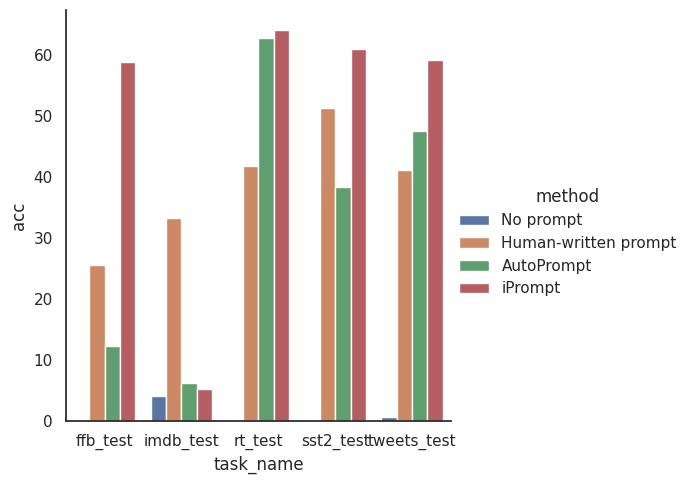

In [61]:
sns.set_theme(style="white")
sns.catplot(data=full_df, kind="bar", x="task_name", y="acc", hue="method", ci=None)